# Traditional Machine Learning

## Goals
1.  Define and use appropriate evaluation metrics (Accuracy, Recall, Precision, F1) for classification.
2.  Implement two traditional ML models and compare their performance:
    -   **Logistic Regression**: Linear Regression with L2 Regularization
    -   **Random Forest Classifier**: Ensemble Model of Decision Trees

In [151]:
# Imports
import json
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from numpy.typing import NDArray
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_validate

In [152]:
# Constants
PROCESSED_DATA_DIR = Path("../../data/cleaned/classification/")
FIGURES_DIR = Path("../../figures/classification/")
MODELS_DIR = Path("../../models/classification/")
MODELS_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [153]:
# Load data
print("Loading feature-engineered data...")
X_train = pl.read_parquet(PROCESSED_DATA_DIR / "X_train_scaled.parquet")
X_val = pl.read_parquet(PROCESSED_DATA_DIR / "X_val_scaled.parquet")
X_test = pl.read_parquet(PROCESSED_DATA_DIR / "X_test_scaled.parquet")

y_train = pl.read_parquet(PROCESSED_DATA_DIR / "y_train.parquet")
y_val = pl.read_parquet(PROCESSED_DATA_DIR / "y_val.parquet")
y_test = pl.read_parquet(PROCESSED_DATA_DIR / "y_test.parquet")

# Convert to numpy for sklearn
X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
X_test_np = X_test.to_numpy()

y_train_np = y_train.to_numpy().ravel()
y_val_np = y_val.to_numpy().ravel()
y_test_np = y_test.to_numpy().ravel()

print(f"X_train: {X_train_np.shape}, y_train: {y_train_np.shape}")
print(f"X_val: {X_val_np.shape}, y_val: {y_val_np.shape}")
print(f"X_test: {X_test_np.shape}, y_test: {y_test_np.shape}")

Loading feature-engineered data...
X_train: (9440, 127), y_train: (9440,)
X_val: (1977, 127), y_val: (1977,)
X_test: (2025, 127), y_test: (2025,)


## Model Evaluation
The following metrics will be used to evaluate the model:
1. **Accuracy**, the proportion of all classifications that were correct, whether positive or negative.
2. **Recall (True Positive Rate)**, the proportion of all actual positives that were classified correctly as positives.
3. **Precision (False Positive Rate)**, the proportion of all the model's positive classifications that are actually positive.
4. **F1 Score**, the harmonic mean (a kind of average) of precision and recall.
5. **Balanced Accuracy**, the mean of the True Positive Rate and the True Negative Rate.
6. **ROC AUC**, how well a model can produce relative scores to discriminate between positive or negative instances across all classification thresholds. 

In [154]:
def evaluate_model(
    model_name: str,
    y_train_pred: NDArray[np.bool],
    y_val_pred: NDArray[np.bool],
    y_train_pred_proba: NDArray[...] = None,
    y_val_pred_proba: NDArray[...] = None,
):
    results = {}
    train_metrics = {
        "Accuracy": accuracy_score(y_train_np, y_train_pred),
        "Precision": precision_score(y_train_np, y_train_pred, zero_division=0),
        "Recall": recall_score(y_train_np, y_train_pred, zero_division=0),
        "F1": f1_score(y_train_np, y_train_pred, zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(y_train_np, y_train_pred),
    }

    if y_train_pred_proba is not None:
        train_metrics["ROC-AUC"] = roc_auc_score(y_train_np, y_train_pred_proba)

    print(f"\033[1m{model_name}: Training Set\033[0m")
    for metric, value in train_metrics.items():
        print(f"  \033[1m{metric:20}:\033[0m {value:.4f}")
    print("")

    results["train"] = train_metrics

    val_metrics = {
        "Accuracy": accuracy_score(y_val_np, y_val_pred),
        "Precision": precision_score(y_val_np, y_val_pred, zero_division=0),
        "Recall": recall_score(y_val_np, y_val_pred, zero_division=0),
        "F1": f1_score(y_val_np, y_val_pred, zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(y_val_np, y_val_pred),
    }

    if y_val_pred_proba is not None:
        val_metrics["ROC-AUC"] = roc_auc_score(y_val_np, y_val_pred_proba)

    print(f"\033[1m{model_name}: Validation Set\033[0m")
    for metric, value in val_metrics.items():
        print(f"  \033[1m{metric:20}:\033[0m {value:.4f}")
    print("")

    # Confusion matrix
    cm = confusion_matrix(y_val_np, y_val_pred)
    print(f"\n\033[1mConfusion Matrix: Validation Set\033[0m")
    print(f"  \033[1mTN:\033[0m {cm[0, 0]:<6} \033[1mFP:\033[0m {cm[0, 1]:<6}")
    print(f"  \033[1mFN:\033[0m {cm[1, 0]:<6} \033[1mTP:\033[0m {cm[1, 1]:<6}")

    results["val"] = val_metrics
    results["confusion_matrix"] = cm

    return results


def report_cv_results(cv_results: dict[...], model_name: str):
    """Extract and report cross-validation metrics."""
    print(f"\033[1m{model_name}: 5-Fold Cross-Validation\033[0m")

    metrics_to_report = ["accuracy", "precision", "recall", "f1", "roc_auc"]

    for metric in metrics_to_report:
        train_key = f"train_{metric}"
        test_key = f"test_{metric}"

        if test_key in cv_results:
            mean = cv_results[test_key].mean()
            std = cv_results[test_key].std()
            print(f"  \033[1m{metric.capitalize():20}:\033[0m {mean:.4f} (±{std:.4f})")

    return {
        metric: {
            "mean": cv_results[f"test_{metric}"].mean(),
            "std": cv_results[f"test_{metric}"].std(),
        }
        for metric in metrics_to_report
        if f"test_{metric}" in cv_results
    }

## Model Performance
We will create a baseline floor (guess 100% superhosts) for comparison, then the two models outlined above.

### Baseline Model (Majority Class Prediction)

In [170]:
baseline_pred_train = np.zeros(len(y_train_np))  # All NOT superhosts
baseline_pred_val = np.zeros(len(y_val_np))

baseline_results = evaluate_model(
    "Baseline Model (No Superhosts)",
    baseline_pred_train,
    baseline_pred_val,
    np.full(len(y_train_np), 0.5),
    np.full(len(y_val_np), 0.5),
)

Baseline Model (No Superhosts): Training Set
  Accuracy            : 0.5714
  Precision           : 0.0000
  Recall              : 0.0000
  F1                  : 0.0000
  Balanced Accuracy   : 0.5000
  ROC-AUC             : 0.5000

Baseline Model (No Superhosts): Validation Set
  Accuracy            : 0.8730
  Precision           : 0.0000
  Recall              : 0.0000
  F1                  : 0.0000
  Balanced Accuracy   : 0.5000
  ROC-AUC             : 0.5000


Confusion Matrix: Validation Set
  TN: 1726   FP: 0     
  FN: 251    TP: 0     


### Logistic Regression (Linear Model)

In [156]:
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver="lbfgs",
    class_weight="balanced",  # Handle imbalance
    n_jobs=-1,
)

# Cross-validation on training set
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results_lr = cross_validate(
    lr_model,
    X_train_np,
    y_train_np,
    cv=cv_strategy,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=True,
    n_jobs=-1,
)

lr_cv_report = report_cv_results(cv_results_lr, "Logistic Regression")

Logistic Regression: 5-Fold Cross-Validation
  Accuracy            : 0.9015 (±0.0070)
  Precision           : 0.8625 (±0.0123)
  Recall              : 0.9165 (±0.0064)
  F1                  : 0.8886 (±0.0073)


In [157]:
# Train final model on full training set
lr_model.fit(X_train_np, y_train_np)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_np)
y_val_pred_lr = lr_model.predict(X_val_np)

lr_results = evaluate_model(
    "Logistic Regression (Linear Model)",
    y_train_pred_lr,
    y_val_pred_lr,
    y_train_pred_proba=lr_model.predict_proba(X_train_np)[:, 1],
    y_val_pred_proba=lr_model.predict_proba(X_val_np)[:, 1],
)

Logistic Regression (Linear Model): Training Set
  Accuracy            : 0.9086
  Precision           : 0.8693
  Recall              : 0.9259
  F1                  : 0.8967
  Balanced Accuracy   : 0.9107
  ROC-AUC             : 0.9641

Logistic Regression (Linear Model): Validation Set
  Accuracy            : 0.8796
  Precision           : 0.5161
  Recall              : 0.8287
  F1                  : 0.6361
  Balanced Accuracy   : 0.8579
  ROC-AUC             : 0.9390


Confusion Matrix: Validation Set
  TN: 1531   FP: 195   
  FN: 43     TP: 208   


#### Analysis

**Performance:**
- Val Accuracy: 87.96% (vs. 90.86% train) -> minimal overfitting 
- Val Precision: 51.61% (vs. 86.93% train) -> concerning, only half of predicted superhosts are correct
- Val Recall: 82.87% (vs. 92.59% train) -> good, captures most actual superhosts
- Val Balanced Accuracy: 85.79% (vs 91.07% train) -> good results for imbalanced data, SMOTE oversampling + majority undersamping worked well

**Confusion Matrix:**
- 195 False Positives vs 43 False Negatives -> model is overly generous in predicting superhosts

The Validation Accuracy is similar to the Training Accuracy, indicating minimal overfitting and good generalization.

The Precision, Recall and Confusion Matrix indicate that the model is too aggressive. This is partly due to 
`class_weight="balanced"` shifting the decision boundary to favor recall over precision.

Ideally, the decision boundary could be tuned above 0.5 to address this.

### Random Forest Classifier

In [158]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    class_weight="balanced",  # Handle imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
)

# Cross-validation
cv_results_rf = cross_validate(
    rf_model,
    X_train_np,
    y_train_np,
    cv=cv_strategy,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    return_train_score=True,
    n_jobs=-1,
    verbose=0,
)

rf_cv_report = report_cv_results(cv_results_rf, "Random Forest Classifier")

Random Forest Classifier: 5-Fold Cross-Validation
  Accuracy            : 0.9677 (±0.0029)
  Precision           : 0.9571 (±0.0063)
  Recall              : 0.9681 (±0.0063)
  F1                  : 0.9625 (±0.0034)
  Roc_auc             : 0.9958 (±0.0005)


In [159]:
# Train final model
rf_model.fit(X_train_np, y_train_np)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_np)
y_val_pred_rf = rf_model.predict(X_val_np)

# Probabilities
y_train_pred_proba = rf_model.predict_proba(X_train_np)
y_val_pred_proba = rf_model.predict_proba(X_val_np)

rf_results = evaluate_model(
    "Random Forest Classifier (Ensemble Model)",
    y_train_pred_rf,
    y_val_pred_rf,
    y_train_pred_proba[:, 1],
    y_val_pred_proba[:, 1],
)

Random Forest Classifier (Ensemble Model): Training Set
  Accuracy            : 0.9872
  Precision           : 0.9790
  Recall              : 0.9913
  F1                  : 0.9851
  Balanced Accuracy   : 0.9877
  ROC-AUC             : 0.9994

Random Forest Classifier (Ensemble Model): Validation Set
  Accuracy            : 0.9611
  Precision           : 0.8199
  Recall              : 0.8884
  F1                  : 0.8528
  Balanced Accuracy   : 0.9300
  ROC-AUC             : 0.9858


Confusion Matrix: Validation Set
  TN: 1677   FP: 49    
  FN: 28     TP: 223   


#### Analysis

**Performance:**
- Val Accuracy: 96.11% (vs. 98.72% train) -> minimal overfitting 
- Val Precision: 81.99% (vs. 97.90% train) -> most predicted superhosts are correct
- Val Recall: 85.28% (vs. 99.13% train) -> captures most actual superhosts
- Val Balanced Accuracy: 93.00% (vs 98.77% train) -> great results for imbalanced data, SMOTE oversampling + majority undersamping worked well

**Confusion Matrix:**
- 49 False Positives vs 28 False Negatives -> model is balanced

The Validation Accuracy is similar to the Training Accuracy, indicating minimal overfitting and good generalization.

In general, the model performs great, even better than Logistic Regression. This indicates that non-linear relationships exist between our input features and target variable, which Random Forest is able to pick up.

## Comparison

In [169]:
# Comparison Table
models = {
    "Baseline": baseline_results,
    "Logistic Regression": lr_results,
    "Random Forest": rf_results,
}

comparison_df = pl.DataFrame(
    {
        "Model": models.keys(),
        "Val Accuracy": [model["val"]["Accuracy"] for model in models.values()],
        "Val Precision": [model["val"]["Precision"] for model in models.values()],
        "Val Recall": [model["val"]["Recall"] for model in models.values()],
        "Val F1": [model["val"]["F1"] for model in models.values()],
        "Val ROC-AUC": [model["val"]["ROC-AUC"] for model in models.values()],
        "Balanced Accuracy": [
            model["val"]["Balanced Accuracy"] for model in models.values()
        ],
    }
)

comparison_df

Model,Val Accuracy,Val Precision,Val Recall,Val F1,Val ROC-AUC,Balanced Accuracy
str,f64,f64,f64,f64,f64,f64
"""Baseline""",0.87304,0.0,0.0,0.0,0.5,0.5
"""Logistic Regression""",0.879616,0.516129,0.828685,0.636086,0.939025,0.857854
"""Random Forest""",0.961052,0.819853,0.888446,0.852772,0.985786,0.930028


**Key Findings:**
1. **RF dominates** across all metrics, especially precision (+30%)
2. RF's precision of 82% vs LR's 51% means RF produces far fewer false positives
3. Both models show good recall (>82%), but RF maintains this while also achieving 
   high precision - a superior trade-off

**Why Random Forest Outperforms:**
- Can capture non-linear relationships (e.g., host_response_time has ordinal nature)
- Handles feature interactions naturally (e.g., experience × response_rate)
- Less affected by feature scaling issues
- 127 features → benefits from ensemble's feature bagging

Text(0.5, 1.0, 'ROC Curves - Validation Set')

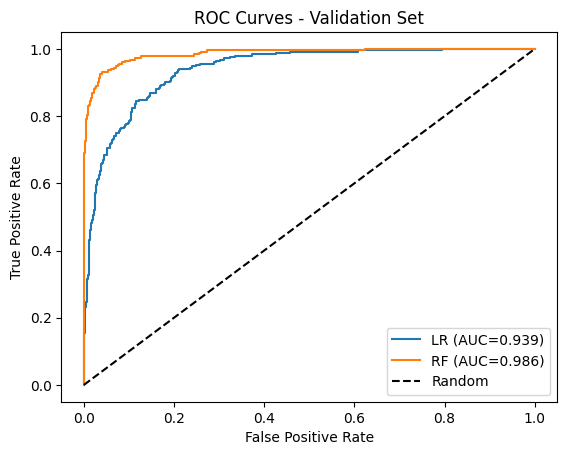

In [161]:
# ROC CURVES
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_val_np, lr_model.predict_proba(X_val_np)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_val_np, rf_model.predict_proba(X_val_np)[:, 1])

plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={0.9390:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={0.9858:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curves - Validation Set")

Text(0.5, 1.0, 'Random Forest')

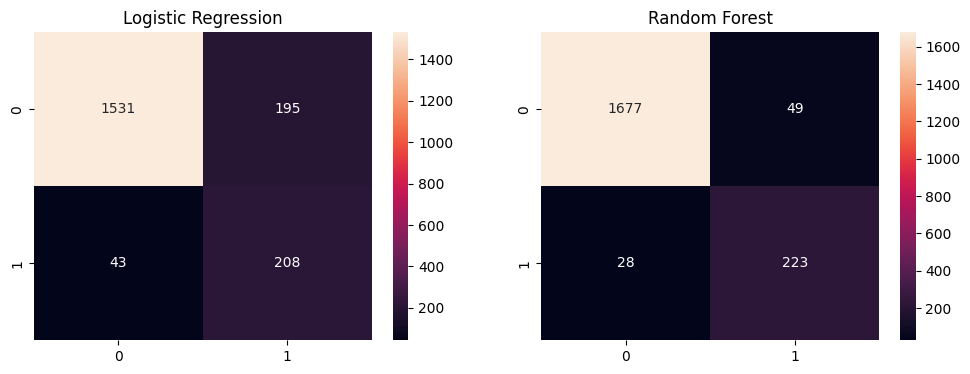

In [162]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_val_np, y_val_pred_lr), annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Logistic Regression")
sns.heatmap(confusion_matrix(y_val_np, y_val_pred_rf), annot=True, fmt="d", ax=axes[1])
axes[1].set_title("Random Forest")

Text(0.5, 1.0, 'Top 20 Features - Random Forest')

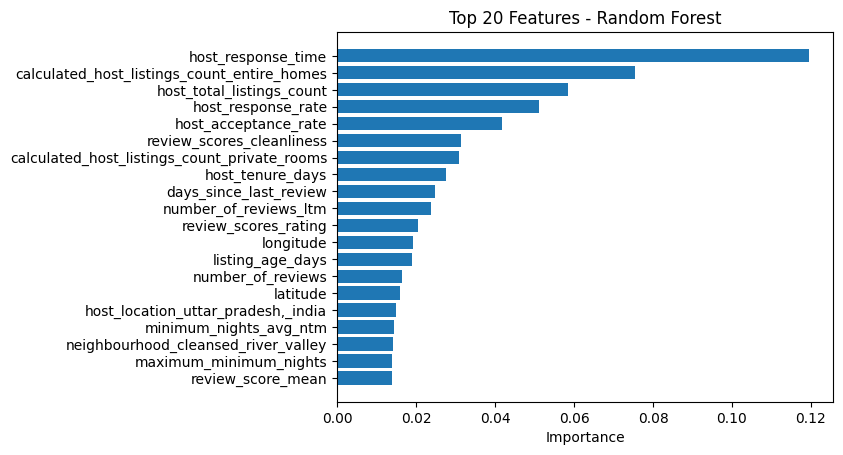

In [163]:
# Feature Importances
importances = rf_model.feature_importances_
feature_names = list(X_train.columns)
top_n = 20
top_idx = np.argsort(importances)[-top_n:]

plt.barh([feature_names[i] for i in top_idx], importances[top_idx])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Features - Random Forest")

In [165]:
# Save Logistic Regression
with open(MODELS_DIR / "logistic_regression.pkl", "wb") as f:
    pickle.dump(lr_model, f)

# Save Random Forest
with open(MODELS_DIR / "random_forest.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Models saved.")

Models saved.
